In [1]:
import matplotlib.pyplot as plt

In [7]:
import torch
from transformers import ViTFeatureExtractor, ViTModel, RobertaTokenizer ,RobertaModel

cache_dir = 'Cache/Transformers'

vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k',cache_dir = 'Cache/Transformers')
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k',cache_dir = 'Cache/Transformers')

gpt_tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base",cache_dir = 'Cache/Transformers')
gpt_model = RobertaModel.from_pretrained("FacebookAI/roberta-base",cache_dir = 'Cache/Transformers')

vit_model.eval()
gpt_model.eval()

def extract_features(image_path):
    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state

def generate_caption(image_features):
    image_features = image_features.mean(dim=1)
    
    gpt_input = gpt_tokenizer("</s>", return_tensors="pt").input_ids
    
    gpt_input = gpt_input.expand(image_features.size(0), -1)

    print(gpt_input.size())
    
    generated_ids = gpt_input
    for _ in range(50):
        
        inputs_embeds = torch.cat((image_features, gpt_input), dim=1)
        print(inputs_embeds.size())
        
        outputs = gpt_model(inputs_embeds=inputs_embeds)
        logits = outputs.logits
        
        next_token_id = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(-1)
        
        gpt_input = torch.cat((gpt_input, next_token_id), dim=1)
        
        if next_token_id.item() == gpt_tokenizer.eos_token_id:
            break
    
    caption = gpt_tokenizer.decode(gpt_input[0], skip_special_tokens=True)
    return caption , image_features

image_path = 'Screenshot (3).png'
image_features = extract_features(image_path)
print(f'Image features:',image_features)

caption,image_featuresm = generate_caption(image_features)

print("Generated Caption:", caption)


c:\Users\chara\anaconda3\envs\torch\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image features: tensor([[[-0.3264, -0.0020, -0.2412,  ..., -0.1265, -0.0052, -0.1583],
         [-0.2307, -0.1131, -0.3720,  ..., -0.1151, -0.0357, -0.2392],
         [-0.2181, -0.1465, -0.3541,  ..., -0.0662, -0.0848, -0.2730],
         ...,
         [-0.2886, -0.0406, -0.2683,  ..., -0.1071, -0.1203, -0.3577],
         [-0.3257, -0.1146, -0.2119,  ..., -0.1811, -0.0428, -0.1757],
         [-0.3337, -0.1845, -0.2936,  ..., -0.1474, -0.0700, -0.1525]]])
torch.Size([1, 3])
torch.Size([1, 771])


ValueError: not enough values to unpack (expected 2, got 1)

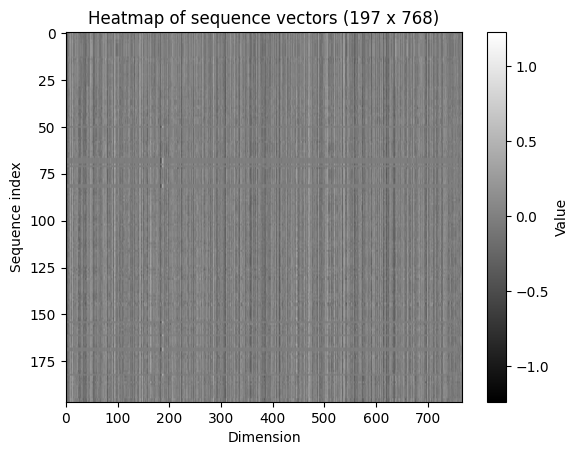

In [ ]:
# Converting tensor to numpy array
matrix = image_features[0, :, :].numpy()

# Plotting as a heatmap
plt.imshow(matrix, aspect='auto', cmap='grey')
plt.title('Heatmap of sequence vectors (197 x 768)')
plt.xlabel('Dimension')
plt.ylabel('Sequence index')
plt.colorbar(label='Value')
plt.show()


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

texts = ["Hello, my dog is cute", "I love machine learning"]

tokenized_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

input_ids = tokenized_inputs['input_ids']
attention_mask = tokenized_inputs['attention_mask']

print("Input IDs:")
print(input_ids)
print("Attention Mask:")
print(attention_mask)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Input IDs:
tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102],
        [  101,  1045,  2293,  3698,  4083,   102,     0,     0]])
Attention Mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0]])


In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")

tokenizer.pad_token = tokenizer.eos_token
text_tk = tokenizer("hello world!",max_length=10, padding="max_length", truncation=True,return_tensors='pt')

In [13]:
print(text_tk['attention_mask'][0])

tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])


In [8]:
from transformers import AutoTokenizer, RobertaForCausalLM, AutoConfig
import torch

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
config = AutoConfig.from_pretrained("FacebookAI/roberta-base")
config.is_decoder = True
model = RobertaForCausalLM.from_pretrained("FacebookAI/roberta-base", config=config)

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

prediction_logits = outputs.logits

In [38]:
import torch
from transformers import BertTokenizer, BertForQuestionAnswering

# Load pre-trained BERT model and tokenizer for QA
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',cache_dir = 'Cache/Transformers')
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased',cache_dir = 'Cache/Transformers')

# Define question and context
question = "Who is the president of the United States?"
context = "The current president of the United States is Joe Biden."

# Tokenize inputs
inputs = tokenizer.encode_plus(question, context, return_tensors='pt', add_special_tokens=True)

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Get start and end logits from model outputs
start_logits = outputs.start_logits
end_logits = outputs.end_logits

# Convert logits to probabilities
start_probs = torch.softmax(start_logits, dim=-1)[0]
end_probs = torch.softmax(end_logits, dim=-1)[0]

# Get the most probable start and end positions
start_index = torch.argmax(start_probs).item()
end_index = torch.argmax(end_probs).item()

# Get answer span from context
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().tolist())
answer = ' '.join(tokens[start_index:end_index+1])

print("Question:", question)
print("Context:", context)
print("Answer:", answer)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Question: Who is the president of the United States?
Context: The current president of the United States is Joe Biden.
Answer: 


In [40]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
vocab = tokenizer.vocab
print("Vocabulary size:", len(vocab))
print("Sample tokens:", list(vocab.keys())[:10])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Vocabulary size: 30522
Sample tokens: ['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]']


In [4]:
from transformers import BertTokenizer

# Instantiate the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
special_tokens_map = tokenizer.special_tokens_map

# Print the special tokens map
special_tokens_map['eos_token']='[EOS]'
print(special_tokens_map['eos_token'])

[EOS]
